[View in Colaboratory](https://colab.research.google.com/github/silentvoice/dl-with-keras/blob/master/convnet-class-activation-heatmaps.ipynb)

# Visualize heatmaps of CAM (class activations maps)

In [0]:
# this resets the state of the machine (e.g. if you want to re-install from scratch  # this  
# or reset memory usage in this instance)
# wait a minute after running it and then reload the page
#!kill -9 -1

## Check Tensorflow Version

In [0]:
import tensorflow as tf

In [63]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [64]:
tf.__version__

'1.9.0-rc2'

## Imports

In [0]:
from tensorflow import keras
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt
import os, shutil
import numpy as np
import cv2

## Import VGG16 Model

In [0]:
model = VGG16(weights='imagenet')

## Import an Image

In [112]:
from google.colab import files
files.upload()

Saving sample.jpg to sample.jpg


{'sample.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xe2\x0cXICC_PROFILE\x00\x01\x01\x00\x00\x0cHLino\x02\x10\x00\x00mntrRGB XYZ \x07\xce\x00\x02\x00\t\x00\x06\x001\x00\x00acspMSFT\x00\x00\x00\x00IEC sRGB\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xd6\x00\x01\x00\x00\x00\x00\xd3-HP  \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x11cprt\x00\x00\x01P\x00\x00\x003desc\x00\x00\x01\x84\x00\x00\x00lwtpt\x00\x00\x01\xf0\x00\x00\x00\x14bkpt\x00\x00\x02\x04\x00\x00\x00\x14rXYZ\x00\x00\x02\x18\x00\x00\x00\x14gXYZ\x00\x00\x02,\x00\x00\x00\x14bXYZ\x00\x00\x02@\x00\x00\x00\x14dmnd\x00\x00\x02T\x00\x00\x00pdmdd\x00\x00\x02\xc4\x00\x00\x00\x88vued\x00\x00\x03L\x00\x00\x00\x86view\x00\x00\x03\xd4\x00\x00\x00$lumi\x00\x00\x03\xf8\x00\x00\x00\x14meas\x00\x00\x04\x0c\x00\x00\x00$tech\x00\x00\x040\x00\x00\x00\x0crTRC\

In [113]:
pwd

'/content'

In [0]:
img_path = '/content/sample.jpg'

In [0]:
img = cv2.imread(img_path)

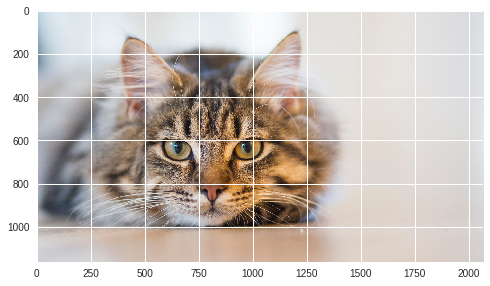

In [119]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Process the image

In [0]:
img = image.load_img(img_path, target_size=(224, 224))

In [0]:
img_tensor = image.img_to_array(img)

In [0]:
img_tensor = np.expand_dims(img_tensor, axis=0)

In [0]:
img_tensor = preprocess_input(img_tensor)

## Create Predictions

In [0]:
preds = model.predict(img_tensor)

In [125]:
decode_predictions(preds, top=3)[0]

[('n02123045', 'tabby', 0.4548116),
 ('n02123159', 'tiger_cat', 0.38437214),
 ('n02124075', 'Egyptian_cat', 0.08035063)]

In [0]:
pred_idx = np.argmax(preds[0])

## Calculate Grad-CAM

In [0]:
output = model.output[: pred_idx] 

In [0]:
last_conv_layer = model.get_layer('block5_conv3')

In [0]:
grads = K.gradients(output, last_conv_layer.output)[0]

In [130]:
grads.shape

TensorShape([Dimension(None), Dimension(14), Dimension(14), Dimension(512)])

In [0]:
pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [0]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

In [0]:
pooled_grads_val, conv_layer_output_val = iterate([img_tensor])

In [134]:
pooled_grads_val.shape

(512,)

In [135]:
conv_layer_output_val.shape

(14, 14, 512)

In [0]:
for i in range(512):
  conv_layer_output_val[:, :, i] *= pooled_grads_val[i]

In [0]:
heatmap = np.mean(conv_layer_output_val, axis=-1)

In [0]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

In [153]:
heatmap.shape

(14, 14)

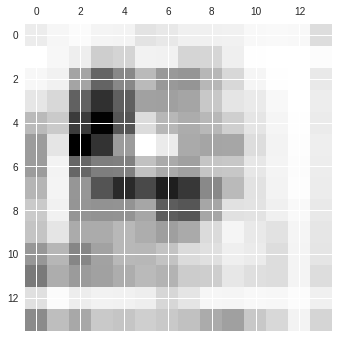

In [154]:
plt.matshow(heatmap)
plt.show()

## Visualize Heatmap

In [0]:
img = cv2.imread(img_path)

In [0]:
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))


In [0]:
heatmap = np.uint8(255 * heatmap)

In [0]:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)

In [0]:
superimposed_img = heatmap * 0.4 + img

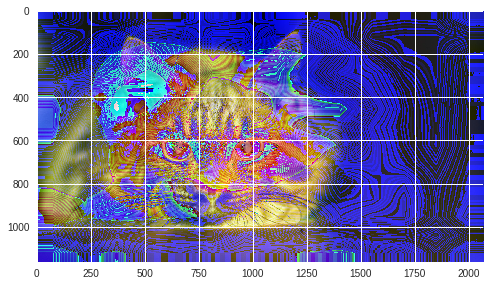

In [161]:
plt.imshow(superimposed_img)
